Calculating average choroid thickness: 100%|██████████| 348/348 [00:01<00:00, 240.78it/s]


Pre-computed average choroid thickness: 59 pixels.


Evaluating:   0%|          | 0/348 [00:00<?, ?it/s]

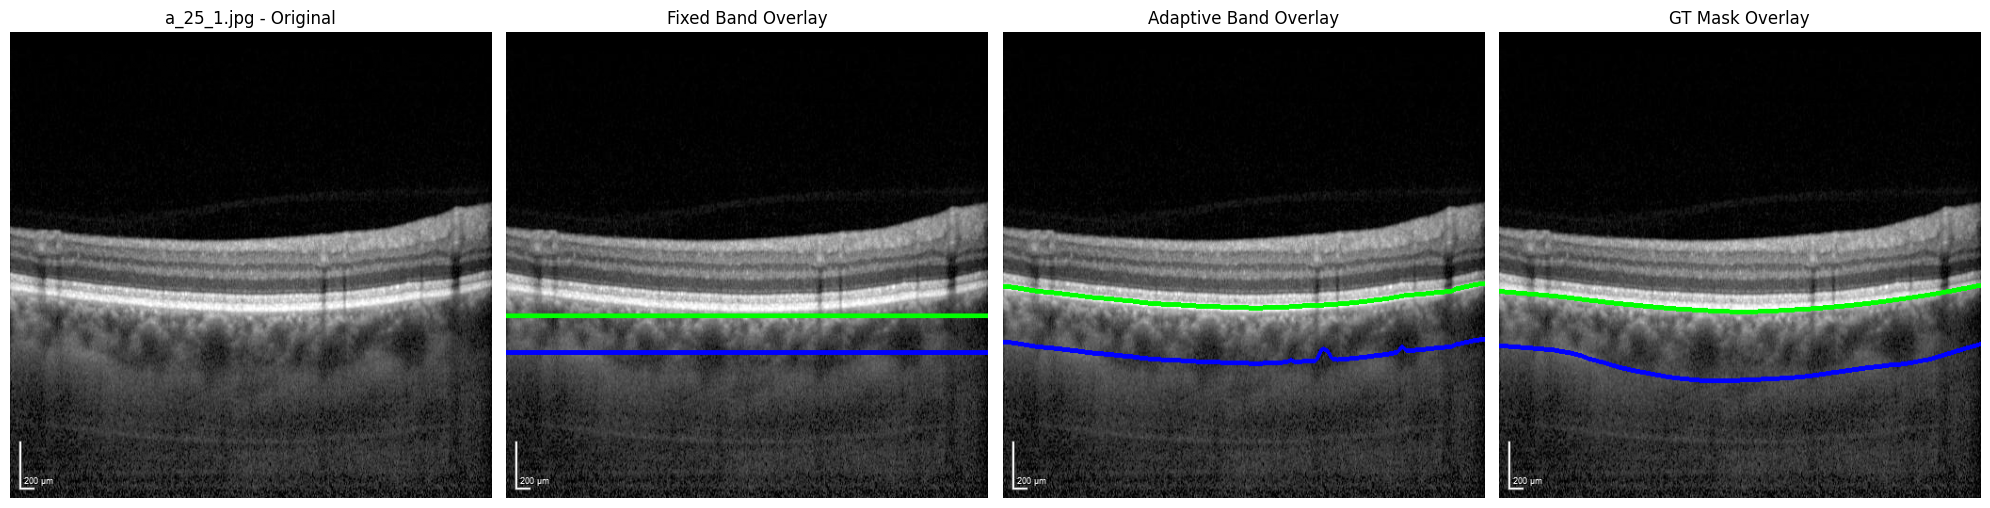

Evaluating:   0%|          | 1/348 [00:00<02:38,  2.19it/s]

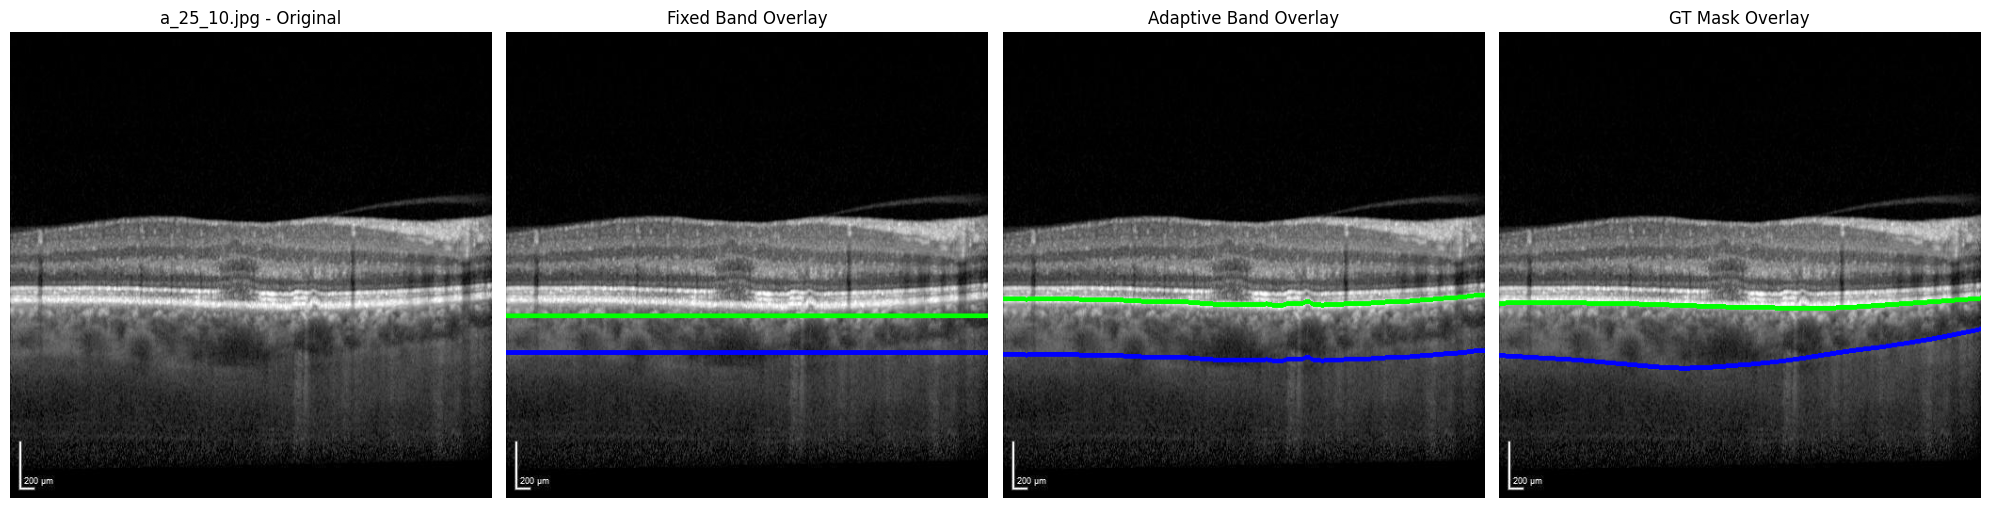

Evaluating:   1%|          | 2/348 [00:00<02:15,  2.56it/s]

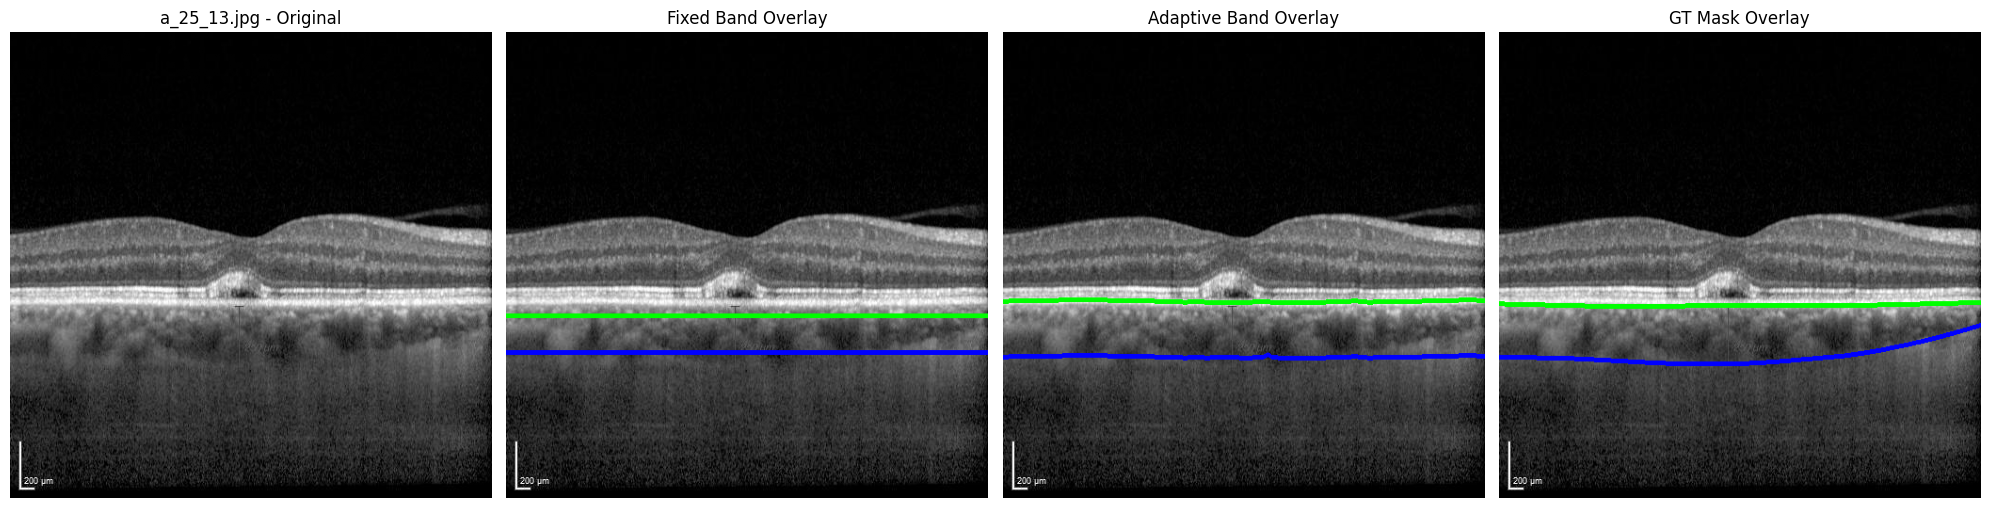

Evaluating:   1%|          | 3/348 [00:01<02:08,  2.69it/s]

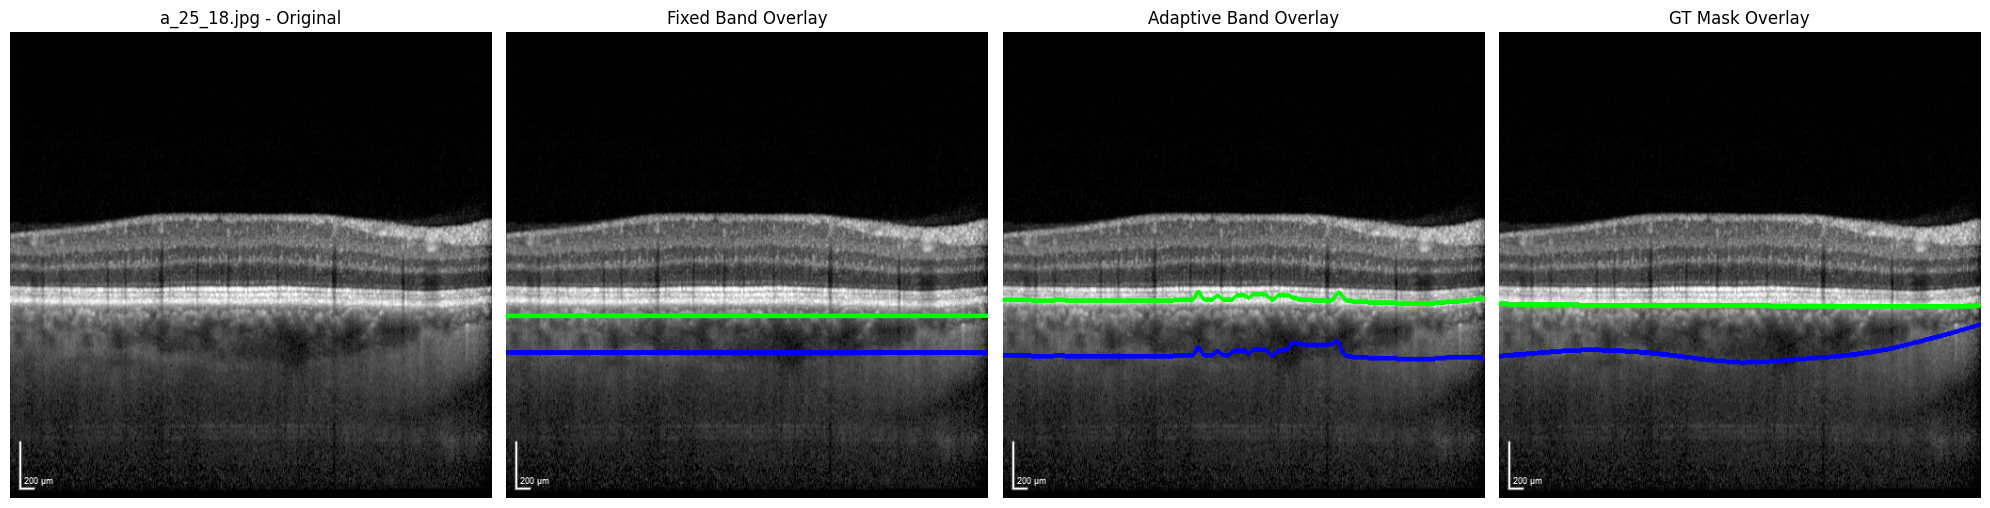

Evaluating:   1%|          | 4/348 [00:01<02:04,  2.76it/s]

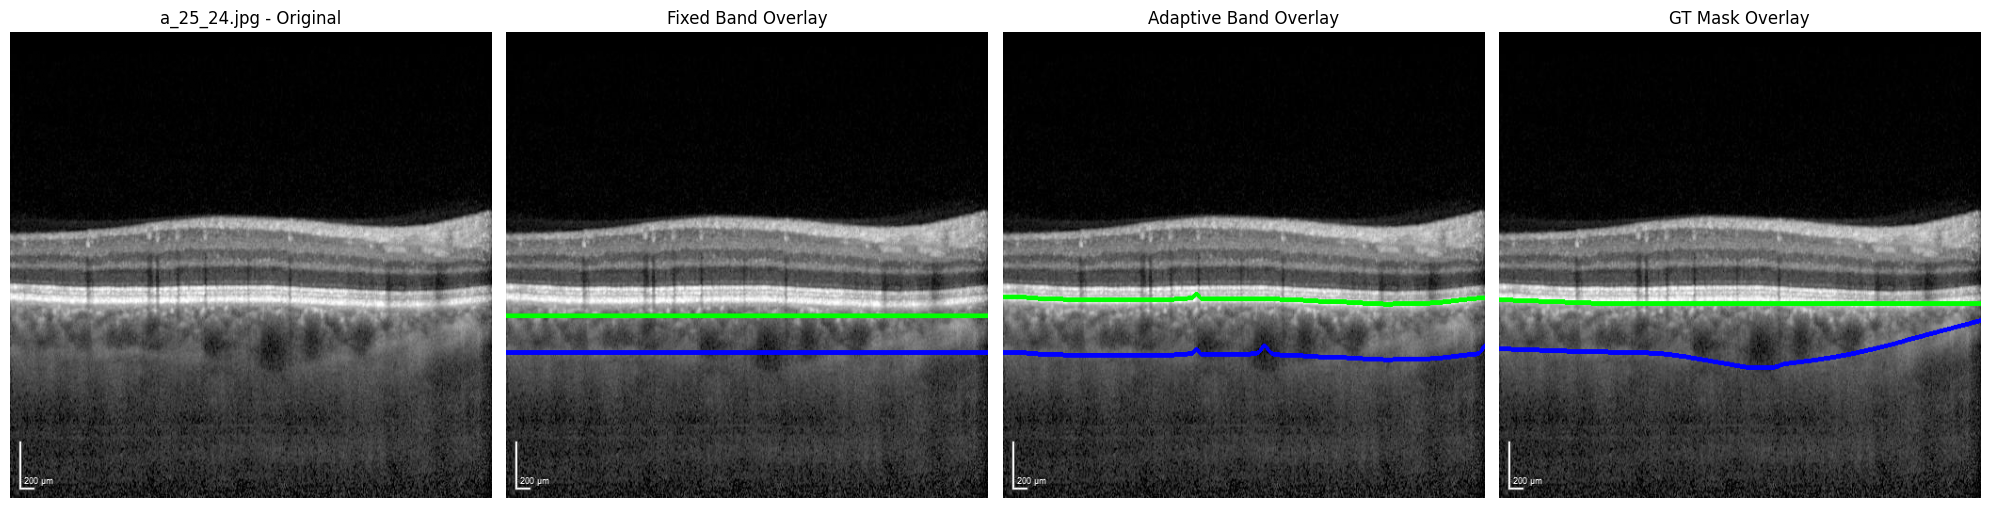

Evaluating: 100%|██████████| 348/348 [00:13<00:00, 24.99it/s]


Results saved to /home/msi/Documents/IIT-H/src/results/Average_mask/band_results.csv


In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.ndimage import gaussian_filter, median_filter
from scipy.stats import pearsonr, spearmanr
import torch
import torch.nn.functional as F

# --- Paths ---
ROOT = "/home/msi/Documents/IIT-H/"
ORG_DIR = os.path.join(ROOT, "src", "training_data", "good_images_all")
GT_MASK_DIR = os.path.join(ROOT, "src", "training_data", "gt_masks_good")
CSV_PATH = os.path.join(ROOT, "src", "results", "IQA_Test", "results_combined_final.csv")
SAVE_PATH = os.path.join(ROOT, "src", "results", "Average_mask", "band_results.csv")

# --- Params ---
GAUSS_SIGMA = 1.0
VALID_EXTS = (".png", ".jpg", ".jpeg", ".bmp", ".tiff")
PAD_MULTIPLE = 16
FIXED_CHOROID_THICKNESS = 40
ADAPTIVE_SMOOTH_SIGMA_TOP = 5
ADAPTIVE_SMOOTH_SIGMA_BOTTOM = 20
MEDIAN_FILTER_SIZE = 7
THICKNESS_SEARCH_RANGE = 30
BOUNDARY_THICKNESS = 3
SPIKE_MAX_JUMP = 10  # max pixels allowed between adjacent columns

# --- Load and resolve image filenames ---
df = pd.read_csv(CSV_PATH)
image_files_on_disk = set(os.listdir(ORG_DIR))

def resolve_filename(base_name):
    for ext in VALID_EXTS:
        fname = base_name + ext if not base_name.lower().endswith(ext) else base_name
        if fname in image_files_on_disk:
            return fname
    return None

df["image_name"] = df["image_name"].apply(resolve_filename)
df = df[df["image_name"].notnull()].reset_index(drop=True)
df = df[["image_name", "dice_score"]]

# --- Metric Function ---
def compute_snr_psnr(signal_region, max_val=255):
    if signal_region.size == 0:
        return np.nan, np.nan
    denoised = gaussian_filter(signal_region, sigma=GAUSS_SIGMA)
    x = signal_region.astype(np.float32).flatten()
    x_hat = denoised.astype(np.float32).flatten()
    power_signal = np.mean(x ** 2)
    mse = np.mean((x - x_hat) ** 2)
    snr = 10 * np.log10(power_signal / (mse + 1e-8))
    psnr = 10 * np.log10((max_val ** 2) / (mse + 1e-8))
    return snr, psnr

# --- Choroid Edge Extractor from GT Mask ---
def get_choroid_edges(mask):
    top = np.zeros(mask.shape[1], dtype=np.int32)
    bottom = np.zeros(mask.shape[1], dtype=np.int32)
    for x in range(mask.shape[1]):
        col = mask[:, x]
        ys = np.where(col > 0)[0]
        if len(ys) > 0:
            top[x] = ys[0]
            bottom[x] = ys[-1]
        else:
            top[x] = 0
            bottom[x] = 0
    return top, bottom

# --- Spike removal for smooth boundaries ---
def remove_spikes(boundary, max_jump=SPIKE_MAX_JUMP):
    smooth_boundary = boundary.copy()
    for i in range(1, len(boundary)):
        diff = smooth_boundary[i] - smooth_boundary[i-1]
        if abs(diff) > max_jump:
            smooth_boundary[i] = smooth_boundary[i-1]  # simple spike removal
    return smooth_boundary

# --- Pre-computation of Average Choroid Thickness ---
mask_files = [f for f in os.listdir(GT_MASK_DIR) if f.lower().endswith(VALID_EXTS)]
thicknesses = []
for fname in tqdm(mask_files, desc="Calculating average choroid thickness"):
    path = os.path.join(GT_MASK_DIR, fname)
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        continue
    top, bottom = get_choroid_edges((mask > 127).astype(np.uint8))
    thickness = bottom - top
    thickness = thickness[thickness > 0]
    if thickness.size > 0:
        thicknesses.extend(thickness.tolist())

avg_choroid_thickness = int(np.mean(thicknesses)) if thicknesses else 100
print(f"Pre-computed average choroid thickness: {avg_choroid_thickness} pixels.")

# --- Adaptive Choroid Edge Extractor ---
def find_adaptive_choroid_boundaries(img, avg_choroid_thickness, THICKNESS_SEARCH_RANGE):
    img_h, img_w = img.shape
    blurred_img = gaussian_filter(img.astype(np.float32), sigma=2)
    
    top_boundary = np.zeros(img_w, dtype=np.int32)
    bottom_boundary_rough = np.zeros(img_w, dtype=np.int32)

    search_start_top = int(img_h * 0.4)
    search_end_top = int(img_h * 0.7)
    for x in range(img_w):
        col_slice = blurred_img[:, x][search_start_top:search_end_top]
        top_boundary[x] = search_start_top + np.argmax(col_slice) if col_slice.size > 0 else search_start_top

    for x in range(img_w):
        search_start_y = top_boundary[x]
        search_end_y = min(img_h, top_boundary[x] + avg_choroid_thickness + THICKNESS_SEARCH_RANGE)
        choroid_region_intensities = blurred_img[search_start_y:min(img_h, top_boundary[x] + avg_choroid_thickness), x]
        if choroid_region_intensities.size > 0:
            reference_intensity = np.median(choroid_region_intensities)
            threshold = reference_intensity * 0.4
            boundary_found = False
            for y in range(search_start_y + 1, search_end_y):
                if blurred_img[y, x] < threshold and blurred_img[y-1, x] >= threshold:
                    bottom_boundary_rough[x] = y
                    boundary_found = True
                    break
            if not boundary_found:
                bottom_boundary_rough[x] = top_boundary[x] + avg_choroid_thickness
        else:
            bottom_boundary_rough[x] = top_boundary[x] + avg_choroid_thickness

    # Smooth and remove spikes
    top_boundary = gaussian_filter(remove_spikes(top_boundary), sigma=2).astype(np.int32)
    bottom_boundary = gaussian_filter(remove_spikes(bottom_boundary_rough), sigma=2).astype(np.int32)
    bottom_boundary = np.maximum(bottom_boundary, top_boundary + 1)

    return top_boundary, bottom_boundary

# --- Padding helper ---
def pad_to_multiple(img_tensor, multiple=16):
    _, _, h, w = img_tensor.shape
    pad_h = (multiple - h % multiple) % multiple
    pad_w = (multiple - w % multiple) % multiple
    return F.pad(img_tensor, (0, pad_w, 0, pad_h), mode='reflect'), (h, w)

# --- Evaluation ---
results = []

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Evaluating"):
    fname = row["image_name"]
    dice = row["dice_score"]
    img_path = os.path.join(ORG_DIR, fname)
    mask_path = os.path.join(GT_MASK_DIR, fname)
    if not os.path.isfile(img_path) or not os.path.isfile(mask_path):
        continue
        
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None: continue

    tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    padded_tensor, _ = pad_to_multiple(tensor, PAD_MULTIPLE)
    img_padded = padded_tensor.squeeze().numpy()
    padded_h, padded_w = img_padded.shape

    # --- Fixed band moved down near choroid ---
    choroid_center = int(padded_h * 0.65)
    fixed_top = choroid_center - FIXED_CHOROID_THICKNESS // 2
    fixed_bottom = choroid_center + FIXED_CHOROID_THICKNESS // 2
    fixed_band = img_padded[fixed_top:fixed_bottom, :]

    # --- Adaptive band ---
    adaptive_top, adaptive_bottom = find_adaptive_choroid_boundaries(img_padded, avg_choroid_thickness, THICKNESS_SEARCH_RANGE)
    adaptive_band = np.zeros_like(img_padded)
    for x in range(padded_w):
        t = adaptive_top[x]
        b = adaptive_bottom[x]
        if 0 <= t < b < padded_h:
            adaptive_band[t:b, x] = img_padded[t:b, x]
    adaptive_band_region = adaptive_band[adaptive_band > 0]

    snr_fixed, psnr_fixed = compute_snr_psnr(fixed_band)
    snr_adaptive, psnr_adaptive = compute_snr_psnr(adaptive_band_region)

    results.append([fname, dice, snr_fixed, psnr_fixed, snr_adaptive, psnr_adaptive])

    if idx < 5:
        # GT edges
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask_tensor = torch.tensor(mask, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        padded_mask_tensor, _ = pad_to_multiple(mask_tensor, PAD_MULTIPLE)
        mask_padded = padded_mask_tensor.squeeze().numpy()
        mask_bin = (mask_padded > 127).astype(np.uint8)
        top_gt, bottom_gt = get_choroid_edges(mask_bin)

        # --- Visualization ---
        img_bgr = np.stack([img_padded.astype(np.uint8)]*3, axis=-1)
        overlay_fixed = img_bgr.copy()
        overlay_adaptive = img_bgr.copy()
        overlay_gt = img_bgr.copy()

        for x in range(padded_w):
            cv2.line(overlay_fixed, (x, fixed_top), (x, fixed_top), (0,255,0), BOUNDARY_THICKNESS)
            cv2.line(overlay_fixed, (x, fixed_bottom-1), (x, fixed_bottom-1), (0,0,255), BOUNDARY_THICKNESS)

            cv2.line(overlay_adaptive, (x, adaptive_top[x]), (x, adaptive_top[x]), (0,255,0), BOUNDARY_THICKNESS)
            cv2.line(overlay_adaptive, (x, adaptive_bottom[x]), (x, adaptive_bottom[x]), (0,0,255), BOUNDARY_THICKNESS)

            cv2.line(overlay_gt, (x, top_gt[x]), (x, top_gt[x]), (0,255,0), BOUNDARY_THICKNESS)
            cv2.line(overlay_gt, (x, bottom_gt[x]), (x, bottom_gt[x]), (0,0,255), BOUNDARY_THICKNESS)

        fig, axes = plt.subplots(1, 4, figsize=(20,5))
        axes[0].imshow(img_padded, cmap='gray')
        axes[0].set_title(f"{fname} - Original")
        axes[1].imshow(overlay_fixed)
        axes[1].set_title("Fixed Band Overlay")
        axes[2].imshow(overlay_adaptive)
        axes[2].set_title("Adaptive Band Overlay")
        axes[3].imshow(overlay_gt)
        axes[3].set_title("GT Mask Overlay")
        for ax in axes: ax.axis('off')
        plt.tight_layout()
        plt.show()

results_df = pd.DataFrame(
    results,
    columns=["image_name", "dice_score", "snr_fixed", "psnr_fixed", "snr_adaptive", "psnr_adaptive"]
)
results_df.to_csv(SAVE_PATH, index=False)
print(f"Results saved to {SAVE_PATH}")